# Credit Card Approvals

#### Import Packages

In [1]:
#Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly as py
import datetime as dt
import scipy as scp

#linear regression
from pylab import *
import statsmodels.api as sm
import statsmodels.stats.api as sms


#Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### Create dFs

In [2]:
applications = pd.read_csv('application_record.csv')
records = pd.read_csv('credit_record.csv')

## Data Exploration and Wrangling

In [3]:
applications.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
records.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [6]:
applications.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [7]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [8]:
# subset data
applications2 = applications.drop(['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1)

In [9]:
# Rename columns
applications2.rename(columns={'CODE_GENDER': 'gender', 'FLAG_OWN_CAR' : 'ownsCar', 'FLAG_OWN_REALTY' : 'ownsRealty', 'CNT_CHILDREN' : 'numChildren', 'AMT_INCOME_TOTAL' : 'totalIncome', 'NAME_INCOME_TYPE' : 'incomeType', 'NAME_EDUCATION_TYPE' : 'EduLvl', 'NAME_FAMILY_STATUS': 'famStatus', 'NAME_HOUSING_TYPE' : 'housingType', 'DAYS_BIRTH' : 'daysBirth', 'DAYS_EMPLOYED' : 'daysEmpl', 'OCCUPATION_TYPE' : 'occupation', 'CNT_FAM_MEMBERS' : 'famSize'}, inplace = True)

In [10]:
# convert daysBirth to Age in years
applications2['age'] = np.ceil(pd.to_timedelta(applications2['daysBirth'], unit='D').dt.days / -365.25)
applications2.drop('daysBirth', axis = 1, inplace = True)

In [11]:
# convert daysEmpl to yrsEmpl
applications2['yrsEmpl']=-applications2['daysEmpl']/365.2425
applications2.loc[applications2['yrsEmpl']<0,'yrsEmpl']=0
applications2.drop('daysEmpl', axis=1, inplace=True)

In [12]:
applications2.head()

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,NaN,2.0,33.0,12.435574
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,NaN,2.0,33.0,12.435574
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,Security staff,2.0,59.0,3.104787
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354


In [13]:
# drop missing values
applications2.dropna(inplace = True)

In [14]:
applications2.head()

,ID,gender,ownsCar,ownsRealty,numChildren,totalIncome,incomeType,EduLvl,famStatus,housingType,occupation,famSize,age,yrsEmpl
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,Security staff,2.0,59.0,3.104787
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,53.0,8.353354


In [15]:
applications2.isna().sum()

ID             0
gender         0
ownsCar        0
ownsRealty     0
numChildren    0
totalIncome    0
incomeType     0
EduLvl         0
famStatus      0
housingType    0
occupation     0
famSize        0
age            0
yrsEmpl        0
dtype: int64

In [16]:
applications2['occupation'].unique()

array(['Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

## Data Visualization

Text(0.5, 1.0, 'Applicant Income Dist')

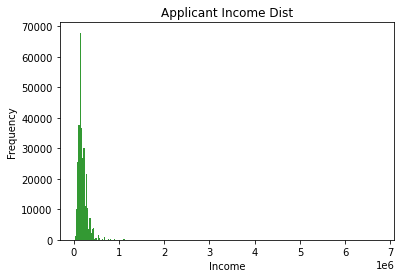

In [17]:
num_bins = 250
n, bins, patches = plt.hist(applications2['totalIncome'], num_bins, facecolor='green', alpha = .8)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Applicant Income Dist')

<AxesSubplot:>

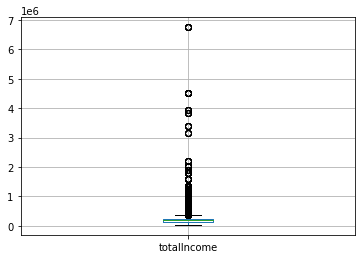

In [18]:
# Look for outliers
applications2.boxplot('totalIncome')

<AxesSubplot:>

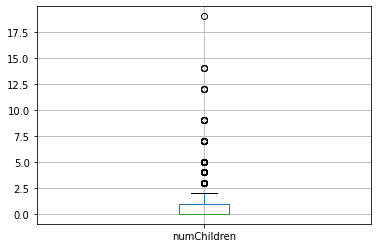

In [19]:
applications2.boxplot('numChildren')

<AxesSubplot:>

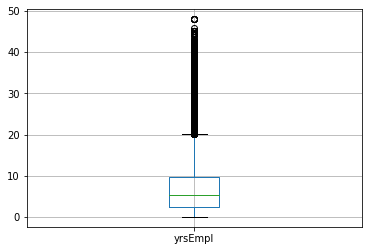

In [20]:
applications2.boxplot('yrsEmpl')

<AxesSubplot:>

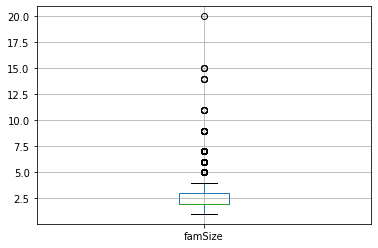

In [21]:
applications2.boxplot('famSize')

Text(0.5, 1.0, 'Distribution of Age')

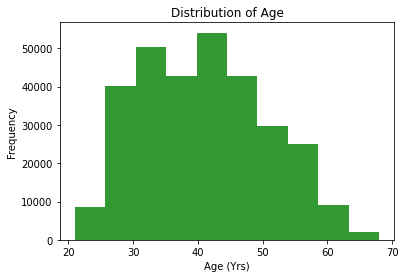

In [22]:
num_bins = 10
n, bins, patches = plt.hist(applications2['age'], num_bins, facecolor='green', alpha = .8)
plt.xlabel('Age (Yrs)')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

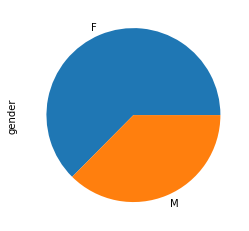

In [23]:
# break up applicants by gender, car ownership, realty ownership
g1 = applications2.groupby('gender')['gender'].count().plot(kind='pie', y='gender')

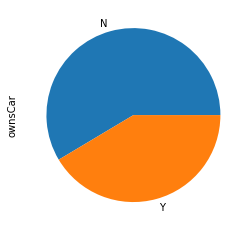

In [24]:
g2 = applications2.groupby('ownsCar')['ownsCar'].count().plot(kind='pie', y='ownsCar')

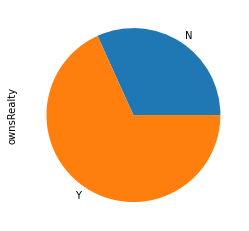

In [25]:
g3 = applications2.groupby('ownsRealty')['ownsRealty'].count().plot(kind='pie', y='ownsRealty')

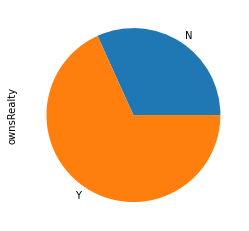

In [26]:
g5 = applications2.groupby('ownsRealty')['ownsRealty'].count().plot(kind='pie', y='ownsRealty')

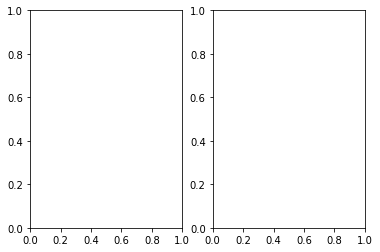

In [ ]:
fig, axes = plt.subplots(1,2)

incTDist=sns.countplot(y=data.incomeType,linewidth=1.2, ax=axes[0])
incTDist.set_title("Customer Distribution by Income Type")
incTDist.set_xlabel("Count")

In [ ]:
# merge the data sets (found that by merging, several data points were created for the same ID depending
# on months balance; use for predictions only, not vintage analysis
merged = pd.merge(applications2, records, on="ID")

In [ ]:
merged.head()

In [ ]:
# drop duplicates
merged=merged.drop_duplicates(subset=merged.columns[1:], keep='first')

In [ ]:
merged.head()